In [28]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import json
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 

In [3]:
# Compile the model with your initial settings
initial_learning_rate = 0.01
initial_batch_size = 32

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 

In [7]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    

In [8]:
cap = cv2.VideoCapture("E:/Thesis/Code/vIDEOS/2A_Trim.mp4")

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()        
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        draw_styled_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

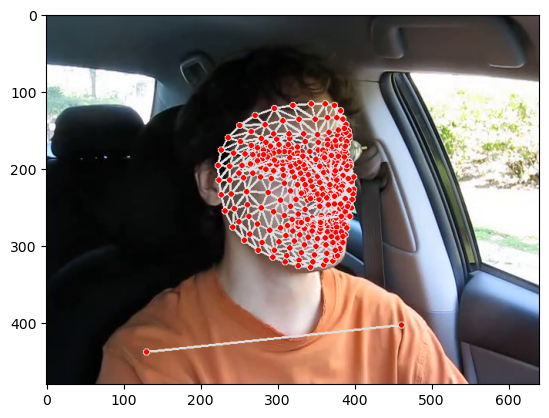

In [9]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [10]:
len(results.face_landmarks.landmark)

468

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose, face])

In [12]:
result_test = extract_keypoints(results)

In [13]:
result_test

array([ 0.57548583,  0.46163172, -0.82323837, ...,  0.60747159,
        0.35757563,  0.05465655])

In [14]:
DATA_PATH = os.path.join('E:/Thesis/Code/DW_Data')
actions = np.array(['Active','Drowsy'])
start_sequence = 0
end_sequence = 239
sequence_length = 10

for action in actions:
    for sequence in range(start_sequence, end_sequence):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass



In [33]:
cap = cv2.VideoCapture("E:/Thesis/Code/vIDEOS/4D_Trim.mp4")
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(start_sequence, end_sequence ):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Data Collection', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Data Collection', image)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
cap.release()
cv2.destroyAllWindows()


In [15]:
label_map = {label:num for num, label in enumerate(actions)}

In [16]:
label_map

{'Active': 0, 'Drowsy': 1}

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in range(start_sequence, end_sequence):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
np.array(sequences).shape

(478, 10, 1536)

In [19]:
np.array(labels).shape

(478,)

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(478, 10, 1536)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1,

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [25]:
y_test.shape

(48, 2)

In [26]:
def build_model(hp):
    input_sequence = Input(shape=(10, 1536))
    length_scale = hp.Float('length_scale', min_value=1e-07, max_value=1.0, sampling='log')
    
   
    lstm1 = LSTM(units=hp.Int('lstm_1_units', min_value=128, max_value=512, step=64),
                 return_sequences=True, activation='relu')(input_sequence)

    
    lstm2 = LSTM(units=hp.Int('lstm_2_units', min_value=128, max_value=512, step=64),
                 return_sequences=True, activation='relu')(lstm1)
    skip_connections = Concatenate()([input_sequence, lstm2])

    lstm3 = LSTM(units=hp.Int('lstm_3_units', min_value=64, max_value=256, step=32),
                 return_sequences=True, activation='relu')(lstm2)
    skip_connections1 = Concatenate()([skip_connections, lstm3])

    lstm4 = LSTM(units=hp.Int('lstm_4_units', min_value=32, max_value=128, step=16),
                 return_sequences=True, activation='relu')(skip_connections1)
    skip_connections2 = Concatenate()([skip_connections1, lstm4])

    lstm5 = LSTM(units=hp.Int('lstm_5_units', min_value=32, max_value=128, step=16),
                 return_sequences=True, activation='relu')(skip_connections2)
    skip_connections3 = Concatenate()([skip_connections2, lstm5])

   
    lstm6 = LSTM(units=hp.Int('lstm_6_units', min_value=16, max_value=64, step=16),
                 return_sequences=True, activation='relu')(lstm5)
    lstm7 = LSTM(units=hp.Int('lstm_7_units', min_value=16, max_value=64, step=16),
                 return_sequences=False, activation='relu')(lstm6)

   
    dense1 = Dense(hp.Int('dense_1_units', min_value=16, max_value=128, step=16), activation='relu')(lstm7)
    dropout1 = Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1))(dense1)
    dense2 = Dense(hp.Int('dense_2_units', min_value=16, max_value=64, step=16), activation='relu')(dropout1)
    output = Dense(actions.shape[0], activation='softmax')(dense2)
    
    model = Model(inputs=input_sequence, outputs=output)
    opt = SGD(learning_rate=initial_learning_rate)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return model


In [27]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=100, restore_best_weights=True)

In [36]:
checkpoint_callback = ModelCheckpoint(filepath='E:/Thesis/Code/sgd_catag/model_checkpoint.h5', save_best_only=True)

In [37]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',  
    num_initial_points=5,     
    max_trials=20,            
    directory='E:/Thesis/Code/sgd_catag/sgd', 
    project_name='E:/Thesis/Code/sgd_catag/sgd/sgd2',    
    overwrite=True
)

In [38]:
tuner.search(X_train, y_train, validation_split=0.2, callbacks=[cb,checkpoint_callback], epochs=100,batch_size=initial_batch_size)

Trial 20 Complete [00h 07m 46s]
val_accuracy: 0.8720930218696594

Best val_accuracy So Far: 0.930232584476471
Total elapsed time: 02h 25m 06s


In [39]:
tuner.results_summary()

Results summary
Results in E:/Thesis/Code/sgd_catag/sgd/sgd2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
length_scale: 0.005069664768965495
lstm_1_units: 192
lstm_2_units: 192
lstm_3_units: 64
lstm_4_units: 32
lstm_5_units: 128
lstm_6_units: 32
lstm_7_units: 64
dense_1_units: 96
dropout_1: 0.2
dense_2_units: 32
Score: 0.930232584476471

Trial 09 summary
Hyperparameters:
length_scale: 7.365568909178954e-05
lstm_1_units: 320
lstm_2_units: 512
lstm_3_units: 96
lstm_4_units: 48
lstm_5_units: 128
lstm_6_units: 64
lstm_7_units: 48
dense_1_units: 48
dropout_1: 0.2
dense_2_units: 48
Score: 0.9186046719551086

Trial 01 summary
Hyperparameters:
length_scale: 0.0009014951821851942
lstm_1_units: 384
lstm_2_units: 256
lstm_3_units: 128
lstm_4_units: 128
lstm_5_units: 112
lstm_6_units: 32
lstm_7_units: 32
dense_1_units: 32
dropout_1: 0.30000000000000004
dense_2_units: 48
Score: 0.895348846912384

Trial 03 summary
Hyperparameters:
length_s

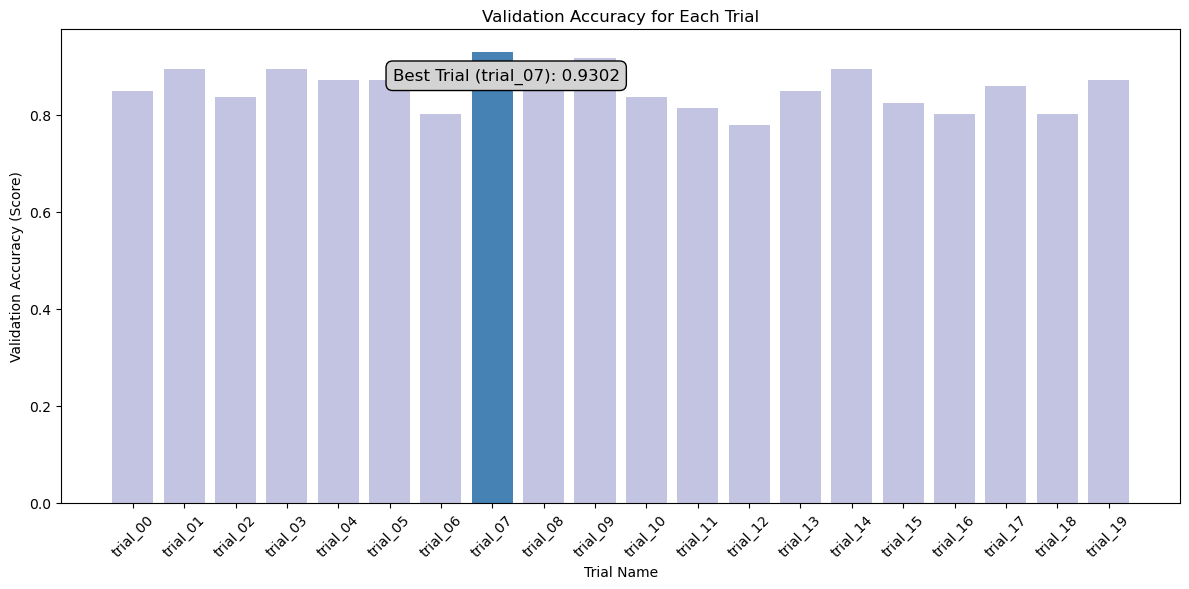

In [41]:
base_dir = "E:/Thesis/Code/sgd_catag/sgd/sgd2/"
trial_scores = []
trial_names = []


for trial_folder in os.listdir(base_dir):
    if trial_folder.startswith("trial_") and os.path.isdir(os.path.join(base_dir, trial_folder)):
        trial_path = os.path.join(base_dir, trial_folder, "trial.json")
        if os.path.exists(trial_path):
            
            with open(trial_path, 'r') as json_file:
                trial_data = json.load(json_file)
                if "score" in trial_data:
                    trial_score = trial_data["score"]
                    trial_scores.append(trial_score)
                    trial_names.append(trial_folder)

best_trial_name = "trial_07"
best_trial_score = trial_scores[trial_names.index(best_trial_name)]


colors = ['#C2C4E2'] * len(trial_names)


best_trial_color = 'steelblue'
colors[trial_names.index(best_trial_name)] = best_trial_color


plt.figure(figsize=(12, 6))
bars = plt.bar(trial_names, trial_scores, color=colors)


plt.annotate(f"Best Trial ({best_trial_name}): {best_trial_score:.4f}",
             xy=(best_trial_name, best_trial_score),
             xytext=(10, -20), textcoords='offset points',
             fontsize=12, ha='center',
             bbox=dict(boxstyle='round,pad=0.4', edgecolor='black', facecolor='lightgrey'))

plt.xlabel('Trial Name')
plt.ylabel('Validation Accuracy (Score)')
plt.title('Validation Accuracy for Each Trial')
plt.xticks(rotation=45)
plt.tight_layout()


image_file_path = 'E:/Thesis/Code/sgd_catag/sgd/bayesian_optimization_results.png'
plt.savefig(image_file_path)


plt.show()


In [42]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [43]:
best_model = tuner.hypermodel.build(best_hps)

In [45]:
checkpoint_callback2 = ModelCheckpoint(filepath='E:/Thesis/Code/sgd_catag/model_checkpoin2.h5', save_best_only=True)

In [47]:
history = best_model.fit(X_train, y_train, epochs=3000,validation_split=0.2,callbacks=[cb,checkpoint_callback2],batch_size=initial_batch_size)

Epoch 1/3000
11/11 [==============================] - 2s 191ms/step - loss: 0.3520 - accuracy: 0.8401 - val_loss: 0.3147 - val_accuracy: 0.8140
Epoch 2/3000
11/11 [==============================] - 2s 188ms/step - loss: 0.3614 - accuracy: 0.8227 - val_loss: 0.2999 - val_accuracy: 0.8488
Epoch 3/3000
11/11 [==============================] - 2s 189ms/step - loss: 0.4136 - accuracy: 0.7849 - val_loss: 0.2701 - val_accuracy: 0.8721
Epoch 4/3000
11/11 [==============================] - 2s 193ms/step - loss: 0.3397 - accuracy: 0.8140 - val_loss: 0.3286 - val_accuracy: 0.8256
Epoch 5/3000
11/11 [==============================] - 2s 189ms/step - loss: 0.3239 - accuracy: 0.8169 - val_loss: 0.2820 - val_accuracy: 0.9186
Epoch 6/3000
11/11 [==============================] - 2s 224ms/step - loss: 0.3439 - accuracy: 0.8459 - val_loss: 0.2430 - val_accuracy: 0.9186
Epoch 7/3000
11/11 [==============================] - 2s 186ms/step - loss: 0.2847 - accuracy: 0.8605 - val_loss: 0.3199 - val_accuracy:

11/11 [==============================] - 3s 295ms/step - loss: 0.2428 - accuracy: 0.8866 - val_loss: 0.2337 - val_accuracy: 0.8721
Epoch 58/3000
11/11 [==============================] - 3s 277ms/step - loss: 0.3001 - accuracy: 0.8605 - val_loss: 0.2013 - val_accuracy: 0.9186
Epoch 59/3000
11/11 [==============================] - 2s 226ms/step - loss: 0.2501 - accuracy: 0.8692 - val_loss: 0.2067 - val_accuracy: 0.8837
Epoch 60/3000
11/11 [==============================] - 2s 221ms/step - loss: 0.3124 - accuracy: 0.8517 - val_loss: 0.2820 - val_accuracy: 0.9186
Epoch 61/3000
11/11 [==============================] - 2s 210ms/step - loss: 0.2734 - accuracy: 0.8779 - val_loss: 0.2757 - val_accuracy: 0.8721
Epoch 62/3000
11/11 [==============================] - 2s 219ms/step - loss: 0.2627 - accuracy: 0.8750 - val_loss: 0.3561 - val_accuracy: 0.8605
Epoch 63/3000
11/11 [==============================] - 2s 198ms/step - loss: 0.3723 - accuracy: 0.8256 - val_loss: 1.0080 - val_accuracy: 0.4767

11/11 [==============================] - 3s 275ms/step - loss: 0.2260 - accuracy: 0.8808 - val_loss: 0.2642 - val_accuracy: 0.8488
Epoch 114/3000
11/11 [==============================] - 3s 277ms/step - loss: 0.2628 - accuracy: 0.8692 - val_loss: 0.2120 - val_accuracy: 0.9535
Epoch 115/3000
11/11 [==============================] - 3s 273ms/step - loss: 0.3199 - accuracy: 0.8692 - val_loss: 0.2945 - val_accuracy: 0.8488
Epoch 116/3000
11/11 [==============================] - 2s 211ms/step - loss: 0.2798 - accuracy: 0.8605 - val_loss: 0.2500 - val_accuracy: 0.9070
Epoch 117/3000
11/11 [==============================] - 5s 486ms/step - loss: 0.2282 - accuracy: 0.8808 - val_loss: 0.3166 - val_accuracy: 0.8488
Epoch 118/3000
11/11 [==============================] - 5s 479ms/step - loss: 0.2733 - accuracy: 0.8721 - val_loss: 0.2158 - val_accuracy: 0.9302
Epoch 119/3000
11/11 [==============================] - 5s 455ms/step - loss: 0.2476 - accuracy: 0.8866 - val_loss: 0.2035 - val_accuracy: 

11/11 [==============================] - 3s 235ms/step - loss: 0.2299 - accuracy: 0.8953 - val_loss: 0.2497 - val_accuracy: 0.8721
Epoch 170/3000
11/11 [==============================] - 3s 295ms/step - loss: 0.2425 - accuracy: 0.8837 - val_loss: 0.2605 - val_accuracy: 0.8837
Epoch 171/3000
11/11 [==============================] - 3s 278ms/step - loss: 0.2311 - accuracy: 0.9041 - val_loss: 0.1925 - val_accuracy: 0.9186
Epoch 172/3000
11/11 [==============================] - 3s 279ms/step - loss: 0.2834 - accuracy: 0.8634 - val_loss: 0.1796 - val_accuracy: 0.9651
Epoch 173/3000
11/11 [==============================] - 3s 224ms/step - loss: 0.1894 - accuracy: 0.9186 - val_loss: 0.2188 - val_accuracy: 0.9651
Epoch 174/3000
11/11 [==============================] - 3s 244ms/step - loss: 0.2734 - accuracy: 0.8692 - val_loss: 0.2946 - val_accuracy: 0.8605
Epoch 175/3000
11/11 [==============================] - 3s 276ms/step - loss: 0.2073 - accuracy: 0.9070 - val_loss: 0.1805 - val_accuracy: 

11/11 [==============================] - 3s 251ms/step - loss: 0.2005 - accuracy: 0.9041 - val_loss: 0.2385 - val_accuracy: 0.9302
Epoch 226/3000
11/11 [==============================] - 2s 223ms/step - loss: 0.1817 - accuracy: 0.9244 - val_loss: 0.1910 - val_accuracy: 0.9419
Epoch 227/3000
11/11 [==============================] - 2s 214ms/step - loss: 0.1967 - accuracy: 0.9128 - val_loss: 0.1474 - val_accuracy: 0.9419
Epoch 228/3000
11/11 [==============================] - 2s 211ms/step - loss: 0.3096 - accuracy: 0.8605 - val_loss: 0.2593 - val_accuracy: 0.8721
Epoch 229/3000
11/11 [==============================] - 2s 211ms/step - loss: 0.2342 - accuracy: 0.8721 - val_loss: 0.2710 - val_accuracy: 0.8953
Epoch 230/3000
11/11 [==============================] - 2s 203ms/step - loss: 0.1753 - accuracy: 0.9215 - val_loss: 0.2969 - val_accuracy: 0.8953
Epoch 231/3000
11/11 [==============================] - 2s 199ms/step - loss: 0.1844 - accuracy: 0.9041 - val_loss: 0.1567 - val_accuracy: 

11/11 [==============================] - 5s 471ms/step - loss: 0.1840 - accuracy: 0.9157 - val_loss: 0.5005 - val_accuracy: 0.7791
Epoch 282/3000
11/11 [==============================] - 5s 475ms/step - loss: 0.2144 - accuracy: 0.9099 - val_loss: 0.2940 - val_accuracy: 0.8837
Epoch 283/3000
11/11 [==============================] - 5s 435ms/step - loss: 0.1637 - accuracy: 0.9506 - val_loss: 0.1792 - val_accuracy: 0.9302
Epoch 284/3000
11/11 [==============================] - 5s 417ms/step - loss: 0.1712 - accuracy: 0.9157 - val_loss: 0.2190 - val_accuracy: 0.8837
Epoch 285/3000
11/11 [==============================] - 5s 414ms/step - loss: 0.1792 - accuracy: 0.9099 - val_loss: 0.1613 - val_accuracy: 0.9302
Epoch 286/3000
11/11 [==============================] - 5s 418ms/step - loss: 0.1587 - accuracy: 0.9215 - val_loss: 0.1596 - val_accuracy: 0.9302
Epoch 287/3000
11/11 [==============================] - 4s 409ms/step - loss: 0.1661 - accuracy: 0.9128 - val_loss: 0.1798 - val_accuracy: 

11/11 [==============================] - 3s 275ms/step - loss: 0.1231 - accuracy: 0.9477 - val_loss: 0.1761 - val_accuracy: 0.8837
Epoch 338/3000
11/11 [==============================] - 3s 272ms/step - loss: 0.1684 - accuracy: 0.9273 - val_loss: 0.2246 - val_accuracy: 0.8837
Epoch 339/3000
11/11 [==============================] - 3s 234ms/step - loss: 0.1420 - accuracy: 0.9448 - val_loss: 0.2032 - val_accuracy: 0.9302
Epoch 340/3000
11/11 [==============================] - 2s 225ms/step - loss: 0.1283 - accuracy: 0.9506 - val_loss: 0.4499 - val_accuracy: 0.8372
Epoch 341/3000
11/11 [==============================] - 3s 274ms/step - loss: 0.4206 - accuracy: 0.8343 - val_loss: 0.3105 - val_accuracy: 0.8488
Epoch 342/3000
11/11 [==============================] - 3s 285ms/step - loss: 0.2412 - accuracy: 0.8866 - val_loss: 0.3739 - val_accuracy: 0.8721
Epoch 343/3000
11/11 [==============================] - 3s 261ms/step - loss: 0.1732 - accuracy: 0.9215 - val_loss: 0.1692 - val_accuracy: 

In [48]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)

2/2 [==============================] - 0s 49ms/step - loss: 0.1105 - accuracy: 0.9583

Test accuracy: 0.9583333134651184

Test Loss: 0.11051073670387268


In [49]:
best_model.save('E:/Thesis/Code/sgd_catag/sgd/sgd_catag.h5')

In [50]:
from tensorflow.keras.models import load_model
loaded_model = load_model('E:/Thesis/Code/sgd_catag/sgd/sgd_catag.h5')

In [51]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 1536)]           0         []                            
                                                                                                  
 lstm_7 (LSTM)               (None, 10, 192)              1327872   ['input_2[0][0]']             
                                                                                                  
 lstm_8 (LSTM)               (None, 10, 192)              295680    ['lstm_7[0][0]']              
                                                                                                  
 concatenate_4 (Concatenate  (None, 10, 1728)             0         ['input_2[0][0]',             
 )                                                                   'lstm_8[0][0]']        

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [53]:
yhat = loaded_model.predict(X_test)

2/2 [==============================] - 1s 45ms/step


In [54]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [55]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[21,  2],
        [ 0, 25]],

       [[25,  0],
        [ 2, 21]]], dtype=int64)

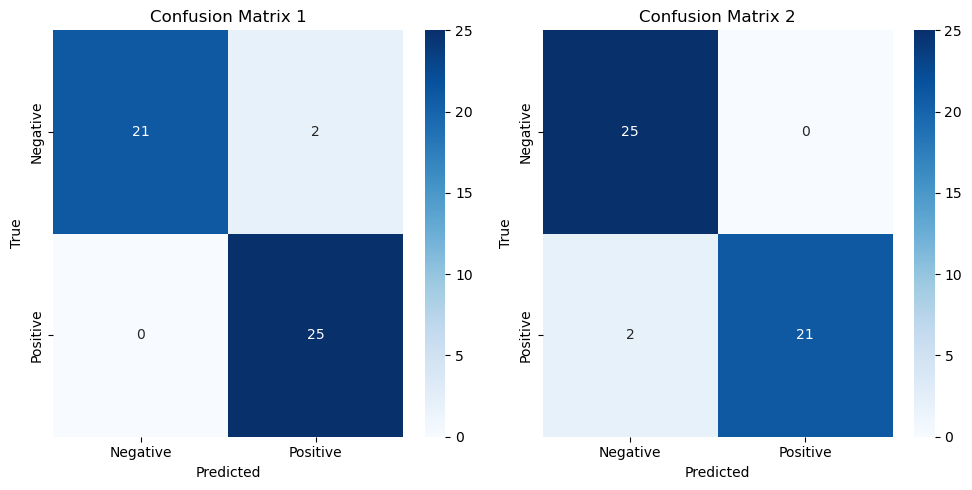

In [56]:


confusion_matrix = [[[21, 2], [0, 25]], [[25, 0], [2, 21]]]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, matrix in enumerate(confusion_matrix):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Confusion Matrix {i+1}')
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].xaxis.set_ticklabels(['Negative', 'Positive'])
    ax[i].yaxis.set_ticklabels(['Negative', 'Positive'])


plt.tight_layout()
plt.savefig('E:/Thesis/Code/sgd_catag/sgd/confusion_matrix.png', format='png')

plt.savefig('E:/Thesis/Code/sgd_catag/sgd/confusion_matrix.pdf', format='pdf')


plt.show()

In [57]:
# Create a Pandas DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Create a PDF file to save the plots
pdf_pages = PdfPages('E:/Thesis/Code/sgd_catag/sgd/training_history.pdf')

# Plot the training history
fig = plt.figure(figsize=(18, 6))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the current figure to the PDF file
pdf_pages.savefig(fig)
plt.close(fig)

# Save the PDF file
pdf_pages.close()

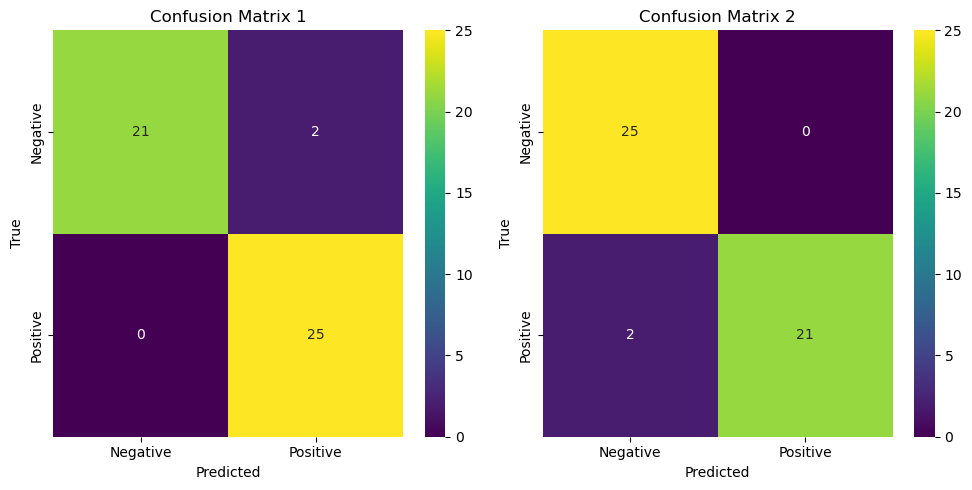

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = [[[21, 2], [0, 25]], [[25, 0], [2, 21]]]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, matrix in enumerate(confusion_matrix):
    sns.heatmap(matrix, annot=True, fmt='', cmap='mako', ax=ax[i])
    ax[i].set_title(f'Confusion Matrix {i+1}')
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].xaxis.set_ticklabels(['Negative', 'Positive'])
    ax[i].yaxis.set_ticklabels(['Negative', 'Positive'])

plt.tight_layout()

# Save the figures in different formats
plt.savefig('E:/Thesis/Code/sgd_catag/sgd/confusion_matrix_colorful.png', format='png')
plt.savefig('E:/Thesis/Code/sgd_catag/sgd/confusion_matrix_colorful.pdf', format='pdf')

# Show the plot
plt.show()


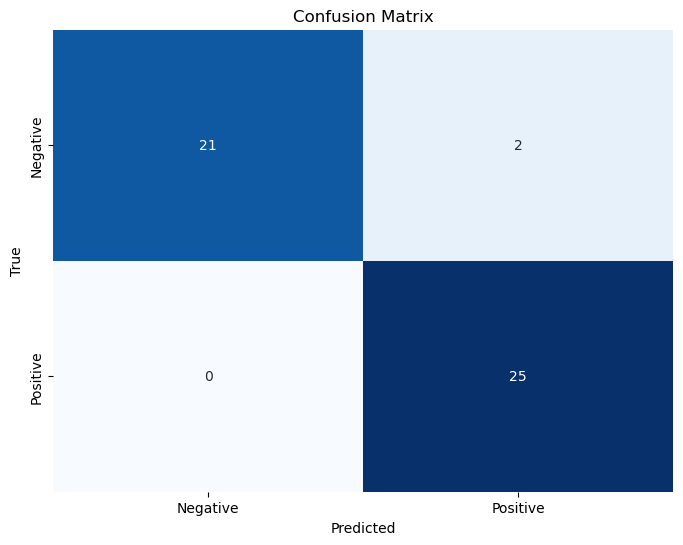

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Given confusion matrix
conf_matrix = [[21, 2],
               [0, 25]]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()